In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [3]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.)


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [4]:
data_resp = pandas2ri.ri2py(data_resp)

In [19]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby("pid")
dots_shown,dots_counted,pct_area,seen=[],[],[],[]
for i,subj in subj_group:
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"]))
    seen.append(list(subj["within_x_tot"]))

ns = [len(n) for n in seen]
min_n = min(ns)

dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
unseen = dots_shown - seen



with pm.Model() as mod:
    #group-level parameters
    
    #mean slope
    b_seen_grp = pm.Normal("b_seen_grp", mu=0,sd=10,testval=1)
    b_unseen_grp = pm.Normal("b_unseen_grp", mu=0,sd=10,testval=1)
    sd_seen_grp = pm.HalfNormal("sd_seen_grp",sd=10,testval=5)
    sd_unseen_grp = pm.HalfNormal("sd_unseen_grp",sd=10,testval=5)
    
    #noise sd
    sd_noise_grp = pm.HalfNormal("b_noise_grp", sd=10,testval=5)

    #alpha hyperparams
    theta_seen_grp = pm.Beta("theta_seen_grp", 1,1)
    theta_unseen_grp = pm.Beta("theta_unseen_grp", 1,1)
    lambda_seen_grp = pm.Exponential("lambda_seen_grp",1)
    lambda_unseen_grp = pm.Exponential("lambda_unseen_grp",1)

    #subject-level parameters
    b_seen_subj = pm.Normal("b_seen_subj",mu=b_seen_grp,sd=sd_seen_grp, shape=(len(seen),1))
    b_unseen_subj = pm.Normal("b_unseen_subj",mu=b_unseen_grp,sd=sd_unseen_grp, shape=(len(unseen),1))
    
    alpha_seen_subj = pm.Beta("alpha_seen_subj",
                                 theta_seen_grp * lambda_seen_grp, 
                                  (1-theta_seen_grp) * lambda_seen_grp, shape=(len(seen),1))
    alpha_unseen_subj = pm.Beta("alpha_unseen_subj",
                                theta_unseen_grp * lambda_unseen_grp, 
                                  (1-theta_unseen_grp) * lambda_unseen_grp, shape=(len(unseen),1))

    b_noise_subj = pm.HalfNormal("b_noise_subj", sd=sd_noise_grp, shape=(len(unseen),1))
    #a_noise_subj = pm.HalfNormal("a_noise_subj", sd=10, shape=(len(unseen),1))

    guess_mean = (b_seen_subj * seen * (1/pct_area) ** alpha_seen_subj + 
                  b_unseen_subj * unseen * (1./(1-pct_area)) ** alpha_unseen_subj)
    noise_mean =  b_noise_subj * guess_mean
    #noise_mean = (1. - pct_area) * b_noise_subj + a_noise_subj

    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=noise_mean, observed=dots_counted)
    trace = pm.sample(steps=2000, tune=500, cores=2)
    


summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_noise_subj_log__, alpha_unseen_subj_logodds__, alpha_seen_subj_logodds__, b_unseen_subj, b_seen_subj, lambda_unseen_grp_log__, lambda_seen_grp_log__, theta_unseen_grp_logodds__, theta_seen_grp_logodds__, b_noise_grp_log__, sd_unseen_grp_log__, sd_seen_grp_log__, b_unseen_grp, b_seen_grp]
100%|██████████| 1000/1000 [01:49<00:00,  9.11it/s]
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7070538265097571, but should be close to 0.8. Try to increase the number of tuning steps.
There were 39 d

                             mean        sd  mc_error       hpd_2.5  hpd_97.5  \
b_seen_grp               0.808215  0.046422  0.002285  7.212575e-01  0.901688   
b_unseen_grp             0.501778  0.090755  0.005262  3.116918e-01  0.670650   
b_seen_subj__0_0         0.757224  0.041232  0.001741  6.821938e-01  0.845195   
b_seen_subj__1_0         0.945613  0.066404  0.003040  8.068738e-01  1.072096   
b_seen_subj__2_0         0.801414  0.066662  0.002787  6.739891e-01  0.933428   
b_seen_subj__3_0         0.821884  0.069883  0.003842  6.800396e-01  0.945594   
b_seen_subj__4_0         0.781782  0.050416  0.002062  6.775068e-01  0.874071   
b_seen_subj__5_0         0.559080  0.041192  0.001586  4.848806e-01  0.643736   
b_seen_subj__6_0         1.031980  0.109233  0.006684  8.141377e-01  1.234637   
b_seen_subj__7_0         0.867374  0.083683  0.004193  7.019322e-01  1.025313   
b_seen_subj__8_0         0.720156  0.044898  0.002000  6.303161e-01  0.809155   
b_seen_subj__9_0         0.7

In [20]:


summary_mean = summary["mean"]

vals = {}
rownames = list(summary.index)
for i in range(len(rownames)):
    rowname = rownames[i]
    if "grp" in rowname:
        rowname = rowname[:rowname.find("_grp")+4]
        val = [summary_mean[i] for _ in range(len(data_resp))]
    elif "subj" in rowname:
        rowname = rowname[:rowname.find("_subj")+5]
        val = [summary_mean[i] for _ in range(ns[i%len(ns)])]
        
    else:
        print(rowname)
        assert(False)
        
    if rowname not in vals:
        vals[rowname] = copy.copy(val)
    else:
        vals[rowname] += copy.copy(val)
        
        
summary_vals = {}
for val in vals:
    summary_vals[val] = vals[val]
    
summary_vals = pd.DataFrame(summary_vals)
for i in data_resp:
    summary_vals[i] = data_resp[i]
pandas2ri.py2ri(summary_vals)


alpha_seen_subj,alpha_unseen_subj,b_noise_grp,...,mean_abs_err,pct_err,abs_pct_err
0.019821,0.249457,0.289106,...,14.000000,-0.466667,0.466667
0.019821,0.249457,0.289106,...,16.000000,-0.400000,0.400000
0.019821,0.249457,0.289106,...,17.000000,-0.531250,0.531250
0.019821,0.249457,0.289106,...,28.000000,-0.571429,0.571429
...,...,...,...,...,...,...
0.013807,0.273323,0.289106,...,1.000000,-0.047619,0.047619
0.013807,0.273323,0.289106,...,25.000000,-0.500000,0.500000


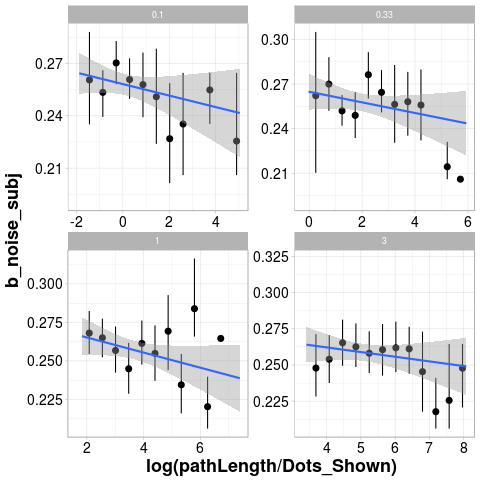

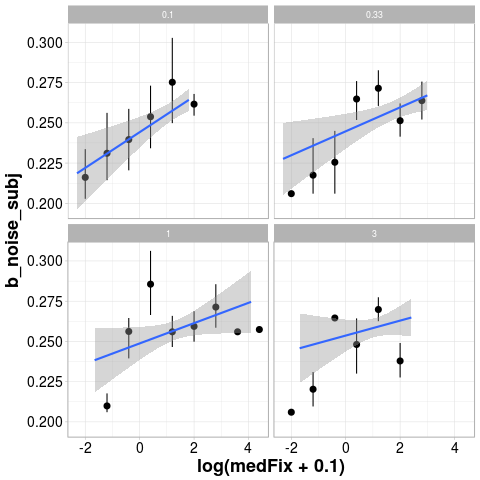

In [68]:
%%R -i summary_vals summary



#get model estimates for each participant
summary_vals <- summary_vals %>%
             mutate(unseen = (Dots_Shown - within_x_tot)) %>%
             mutate(model_guess = b_seen_subj * within_x_tot * ((1/pctArea) ** alpha_seen_subj) + 
                        b_unseen_subj * unseen * (1./(1.-pctArea))**alpha_unseen_subj) %>%
             mutate(model_noise = b_noise_subj * model_guess) 
            # mutate(model_noise = (1.-pctArea) * b_noise_subj + a_noise_subj ) 

#just the mean values of parameters
#estimated in the regression
mean_reg_vals <- summary_vals %>%
                group_by(pid) %>%
                mutate(mean_PL=mean(pathLength)) %>%
                top_n(n=1,wt=id)

p.1 <- ggplot(data=summary_vals) +
        geom_errorbar(aes(x=Dots_Shown, ymin=model_guess - model_noise,
                                  ymax=model_guess+model_noise, color="Model"), alpha=0.04,width=1,size=10) +
        geom_point(aes(x=Dots_Shown, y=Dots_Counted,color="Human")) +
        scale_color_manual(values=c("black","blue")) +
 
        facet_wrap(~pid) +
        paper_theme_2 + theme(legend.title=element_blank(), legend.text=element_text(size=14)) +
        ggtitle("Model predictions") +
        geom_abline(linetype="dashed")

p.2 <- ggplot(data=mean_reg_vals) +
        geom_point(aes(x=b_seen_subj, y=b_unseen_subj)) +
        geom_point(aes(x=b_seen_grp, y=b_unseen_grp),color="red", size=5, shape=3) +

        paper_theme_2 +
        geom_abline() +
        xlim(0,1.5) + ylim(0,1.5) +
        xlab("b_focal") + ylab("b_peripheral") +
        ggtitle("Focal v. peripheral contribution to mean (unscaled)")

 
p.3 <- ggplot(data=mean_reg_vals) +
        geom_point(aes(x=alpha_seen_subj, y=alpha_unseen_subj)) +
        geom_point(aes(x=theta_seen_grp, y=theta_unseen_grp),color="red", size=5, shape=3) +

        paper_theme_2 + theme(legend.title=element_blank()) +
        #geom_abline() +
        geom_hline(aes(yintercept=0.5)) +
        geom_vline(aes(xintercept=0.5)) +

        xlim(0,1) + ylim(0,1) +
        geom_text(aes(x=0.35,y=0.35, label="<- accumulator"), inherit.aes=FALSE, size=6, angle=45) +
        geom_text(aes(x=0.6,y=0.6, label="density ->"), inherit.aes=FALSE, size=6, angle=45) +

        xlab("alpha_focal") + 
        ylab(" alpha_peripheral") +
        ggtitle("Focal v. peripheral re-scaling") 



range_pl <- range(log(summary_vals$pathLength))
p.4 <- ggplot(data=summary_vals, aes(x=log(pathLength/Dots_Shown), y=b_noise_subj)) +
        stat_summary_bin(bins=12, fun.data="mean_cl_boot") +
      #  geom_point() + 
        stat_smooth(method="lm") +
            facet_wrap(~factor(Time), scale="free") +
              #scale_x_continuous(limits = range_pl) +

            paper_theme_2 
        
range_med <- range(log(summary_vals$medFix+1))
p.5 <- ggplot(data=summary_vals, aes(x=log(medFix+0.1), y=b_noise_subj)) +
        #geom_point() + 
        stat_summary_bin(bins=8, fun.data="mean_cl_boot") +
       # stat_summary(fun.data="mean_cl_boot") +
            stat_smooth(method="lm") +

            facet_wrap(~factor(Time)) +
              scale_x_continuous(limits = range_med) +


            paper_theme_2 


#print(p.1)
#print(p.2)
#print(p.3)
print(p.4)
print(p.5)